# Denoising Diffusion Probabilistic Models (DDPM)

In this notebook, you will implement step-by-step a simple Denoising Diffusion Probabilistic Model using PyTorch, based on the paper by [Ho et al., 2020](https://arxiv.org/abs/2006.11239). You will be able to train a model on the MNIST dataset to generate new MNIST images, and then to load a pretrained model to generate images from other datasets.

## IMPORT

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision


import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import logging
import os

## CONFIG

This configuration sets parameters for a diffusion process

In [66]:
IMG_SIZE = 32 # Power of 2
NUM_CHANNELS = 1 # Grayscale: 1
NOISE_STEPS = 1000

BATCH_SIZE = 32
NUM_EPOCHS = 20
LR = 1e-5 # learning rate

NB_VISUALISATION = 5 # Number of epochs between each visualization during training

# Set up logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DATA

This section loads the MNIST dataset to train our model

In [68]:
fraction = 0.5 # portion of the dataset (60000 total)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
    torchvision.transforms.ToTensor()
])

mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
num_samples = int(len(mnist_data) * fraction)
indices = np.random.choice(len(mnist_data), num_samples, replace=False)
subset_data = torch.utils.data.Subset(mnist_data, indices)
dataloader = torch.utils.data.DataLoader(subset_data, batch_size=BATCH_SIZE, shuffle=True)

In [69]:
print("Nb images in DataLoader :", len(dataloader.dataset))

Nb images in DataLoader : 30000


In [70]:
def show_images(dataloader, num_images=6):
    _, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        images, _ = next(iter(dataloader))
        image = images[i].numpy()
        ax = axes[i]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
        
    plt.show()

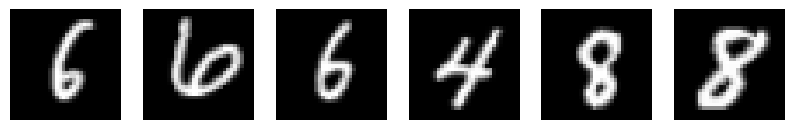

In [71]:
show_images(dataloader)

## DIFFUSION

The `Diffusion` class is designed to manage the process of adding Gaussian noise to an image at a specific timestep $t$ and to reverse this diffusion process, reconstructing images from noise, step by step, until reaching $t=0$. The class also incorporates a scheduler (linear) to establish and control the parameters `beta` and `alpha`, which are crucial for dictating the noise levels and the progression of the diffusion process.

### Forward Diffusion Process
In the forward diffusion process, at each timestep $t$, the image $x_{t-1}$ is incrementally noised following a conditional Gaussian distribution:

$$x_t = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon,$$

where $\epsilon \sim \mathcal{N}(0, I)$ represents standard Gaussian noise, and $\beta_t$ is a parameter controlling the noise intensity at step $t$. An important property is that sums of Gaussians are also Gaussian. This significantly simplifies the process of generating noise, as at each step $t$, it is not necessary to iterate through all previous steps. Thus, noise can be generated directly at step $t$, enhancing the efficiency of the learning process.


The equation used to actually apply the noise in code is:

$$
x_t = \sqrt{\alpha_{\text{hat},t}} \times x + \sqrt{1 - \alpha_{\text{hat},t}} \times \epsilon
$$


The parameters $\alpha_t = 1 - \beta_t$ and $\alpha_{\text{hat}, t} = \prod_{i=1}^t \alpha_i$ determine the proportion of the original image preserved and the cumulative noise reduction across steps, respectively. $\epsilon$ is a Gaussian noise.
This equation represents the decomposition of the noising process into a part that scales the original image by the cumulative root of the preserved noise $\sqrt{\alpha_{\text{hat},t}}$ and a part that adds scaled Gaussian noise $\sqrt{1 - \alpha_{\text{hat},t}} \times \epsilon$.

**To Do**: Implement the `forward_diffusion` function. This should return the noised_image and the noise.


### Reverse Diffusion Process
The reverse diffusion process aims to reconstruct the original image from the noisy state. Starting from $x_T$ (where $T$ is the last step, mostly pure noise), the image is progressively "denoised" by estimating the noise added at each step:

$$x_{\text{t-1}} = \frac{1}{\sqrt{\alpha}} \left( x - \frac{1 - \alpha}{\sqrt{1 - \alpha_{\text{hat}}}} \cdot \epsilon_t \right) + \sqrt{\beta} \times \epsilon$$


where $\epsilon_t$ is the noise predicted by the model at step $t$. To explore the space more effectively during the denoising, a Gaussian noise term $\sqrt{\beta_t} \times \epsilon$ is added. This term introduces a controlled amount of randomness back into the process, helping to sample from nearby states in the probability distribution. For $t=1$, this noise term is set to zero to ensure that the final denoising step precisely targets the original data distribution without additional noise interference.

**To Do**: Implement the `reverse_diffusion` function to reconstruct the original image from its noisy state at a timestep t.

In [72]:
class Diffusion:
    def __init__(self, noise_steps=NOISE_STEPS, beta_start=0.0001, beta_end=0.02, img_size=IMG_SIZE, device='cuda'):
        """
        Initialize the Diffusion class.
       
        Attributes:
            noise_steps (int): Number of steps in the diffusion process.
            beta_start (float): Starting value of beta.
            beta_end (float): Ending value of beta.
            img_size (int): Size of the images.
            device (str): Device to run computations on.
            beta (torch.Tensor): Tensor containing linearly spaced beta values.
            alpha (torch.Tensor): Tensor containing corresponding alpha values.
            alpha_hat (torch.Tensor): Cumulative product of alpha values.
        """
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
        self.alpha = 1.0 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def to(self, device):
        """
        Move all model tensors to the specified device.
        """
        if device != self.device:
            if device == "cpu":
                logging.warning("Moving tensors to CPU. This might affect performance.")
            elif device == "cuda":
                logging.info("Moving tensors to CUDA")
                
            self.device = device
            self.beta = self.beta.to(device)
            self.alpha = self.alpha.to(device)
            self.alpha_hat = self.alpha_hat.to(device)
        else:
            logging.info("All tensors are already on the specified device: {}".format(device))
        return self

    def forward_diffusion(self, x, t):
        """
        Add noise to the images according to the timestep t.

        Args:
            x (torch.Tensor): Input images.
            t (torch.Tensor): Timestep values.

        Returns:
            tuple: Tuple containing the noised images and the noise.
        """
        t = t.flatten()
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x)
        noised_images = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise      
        return noised_images, noise

    def reverse_diffusion(self, model, x, start_t=None, num_images_to_return=None):
        """
        Reverse diffusion process to generate images or observe steps from a specific t to t=0.

        Args:
            model: The model used to predict noise.
            x: Initial images or noise.
            start_t (int, optional): Initial timestep of reverse diffusion. Defaults to None (last step).
            num_images_to_return (int, optional): Number of additional images to return in addition to the final image (for visualisation). Defaults to None

        Returns:
            list: List of tuples containing reversed images and their corresponding timestep.
        """
        denoised_sample = []
        if num_images_to_return is None:
            num_images_to_return = 1
        
        if start_t is None:
            start_t = self.noise_steps - 1
        
        for i in reversed(range(1, start_t + 1)):
            t = (torch.ones(1) * i).long().to(self.device)
            predicted_noise = model(x, t)
            alpha = self.alpha[t][:, None, None, None]
            alpha_hat = self.alpha_hat[t][:, None, None, None]
            beta = self.beta[t][:, None, None, None]
            noise = torch.randn_like(x) if i > 1 else torch.zeros_like(x) 
            x = 1 / torch.sqrt(alpha) * (x - (1 - alpha) / torch.sqrt(1 - alpha_hat) * predicted_noise[0]) + torch.sqrt(beta) * noise
            
            if num_images_to_return > 1:
                if(i % int(start_t/(num_images_to_return-1)) == 0):
                    denoised_sample.append((x,i))

        denoised_sample.append((x, i))
        return denoised_sample


## Unet

The UNet will be implemented to take a noised image at a specific timestep and output the predicted noise, essentially inverting the forward diffusion process. This model does not merely reproduce the input image; rather, it discerns and subtracts the added noise, for a step-by-step denoising until the original image is restored.

The UNet is structured with a series of convolutional layers that descend into significant feature depths before ascending back to the output, matching the input image size.

For example, in this specific diagram for the model, the U-Net takes an input of a 572x572 image with a single channel, progressing through successive stages of convolution and pooling to reach up to 1024 features at the deepest level. However, for smaller images such as 32x32, descending to 1024 features is not necessary; a depth of 512 is entirely sufficient.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt="Alternative text" width="1200" height="800" />

`DoubleConv` class defines a sequence of two consecutive convolutional layers, followed by group normalization (GroupNorm) and GELU activation (Gaussian Error Linear Unit). It can also include a residual connection, which is a technique used to facilitate learning by allowing information to pass directly through the layers without excessive modifications.

`Down`: Each `Down` module in the contracting path consists of a max pooling operation followed by two DoubleConv layers. The max pooling reduces the spatial dimensions of the feature maps
Each `Down` module also integrates temporal information through an embedding layer, which processes a temporal dimension (t) and merges this information with the feature maps. This temporal integration is critical for tasks where the input's characteristics change over time, such as during the progression of noise addition to an image.

`Bottleneck` does not involve downsampling but focuses on processing the deepest and most compressed feature representations. This part of the network uses several DoubleConv layers to intensively process features, preparing them for expansion and detailed reconstruction.

`Up`: In the expansive path, each `Up` module employs upsampling to increase the spatial dimensions of the feature maps. It uses bilinear interpolation for a smooth increase in size, followed by a concatenation with corresponding feature maps from the contracting path through skip connections. These skip connections reintroduce spatial details lost during downsampling, essential for precise localization and detail in image reconstruction. After concatenation, the feature maps go further processing with DoubleConv layers, again incorporating temporal embeddings to adjust the output based on the temporal information.

**To do**: Complete the UNet function as well as its forward method for passing images through the model. You may or may not use the pre-built classes defined above.

In [73]:
class DoubleConv(nn.Module):
    """ 
    Double convolution layers with GroupNorm and GELU activation. Optionally includes a residual connection.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        mid_channels (int, optional): Number of channels in the intermediate layer. Defaults to None.
        residual (bool, optional): Whether to include a residual connection. Defaults to False.
    """
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()

        self.residual = residual
    
        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):

        if self.residual:
            output = F.gelu(x + self.double_conv(x))
        else:
            output = self.double_conv(x)
            
        return output


class Down(nn.Module):
    """ 
    Downsampling layer with MaxPooling, DoubleConv, and temporal representation.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        emb_dim (int, optional): Dimension of the temporal embedding. Defaults to 256.
    """
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, t):

        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        output = x + emb

        return output


class Up(nn.Module):
    """ 
    Upsampling layer with Upsample and DoubleConv. Also integrates temporal representation.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        emb_dim (int, optional): Dimension of the temporal embedding. Defaults to 256.
    """
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )
        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x, t):
        
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        output = x + emb
    
        return output


class UNet(nn.Module):
    """ 
    Modular U-Net architecture.

    Args:
        c_in (int, optional): Number of input channels. Defaults to NUM_CHANNELS.
        c_out (int, optional): Number of output channels. Defaults to NUM_CHANNELS.
        time_dim (int, optional): Dimension of the temporal representation. Defaults to 256.
        device (str, optional): Device to run the model on. Defaults to DEVICE.
    """
    def __init__(self, c_in=NUM_CHANNELS, c_out=NUM_CHANNELS, time_dim=256, device=device):
        super().__init__()

        self.device = device
        self.time_dim = time_dim
        
        self.inc = DoubleConv(c_in, 64)
        
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 64)

        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        """
        Compute positional encoding for temporal representation.

        Args:
            t (torch.Tensor): Temporal representation tensor.
            channels (int): Number of channels.

        Returns:
            torch.Tensor: Positional encoding tensor.
        """
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t=None):
        """
        Forward pass of the UNet model.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor, optional): Temporal representation tensor. Defaults to None.

        Returns:
            torch.Tensor: Output tensor.
        """
        logging.debug(x.shape)
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        logging.debug(x1.shape)
        
        x2 = self.down1(x1, t)
        logging.debug(x2.shape)
        x3 = self.down2(x2, t)
        logging.debug(x3.shape)
        x4 = self.down3(x3, t)
        logging.debug(x4.shape)
        
        x4 = self.bot1(x4)
        logging.debug(x4.shape)
        x4 = self.bot2(x4)
        logging.debug(x4.shape)
        x4 = self.bot3(x4)
        logging.debug(x4.shape)

        x = self.up1(x4, x3, t)
        logging.debug(x.shape)
        x = self.up2(x, x2, t)
        logging.debug(x.shape)
        x = self.up3(x, x1, t)
        logging.debug(x.shape)

        output = self.outc(x)
        return output


## TRAIN

Let's now train our model using PyTorch. We'll follow the typical training loop procedure. During each iteration of training:

1. **Image Retrieval and Noising**: We retrieve an image from the data loader and add noise at a random timestamp `t`, which is selected between 1 and `noise_steps`.
   
2. **Forward Diffusion**: Apply the `forward_diffusion` process to the image at the specified timestep `t`. This generates a noised version of the image.

3. **Model Prediction**: Feed the noised image into the model along with the timestep `t`. The model outputs a prediction of the noise that has been added to the image.

4. **Loss Calculation and Backward Pass**: Calculate the loss between the predicted noise and the actual noise applied during the forward diffusion. Perform the backward pass to compute the gradients.

5. **Model Training**: Update the model parameters using the Adam optimizer.

Epoch 1/20: 100%|██████████| 938/938 [00:54<00:00, 17.20it/s, loss=0.0935]


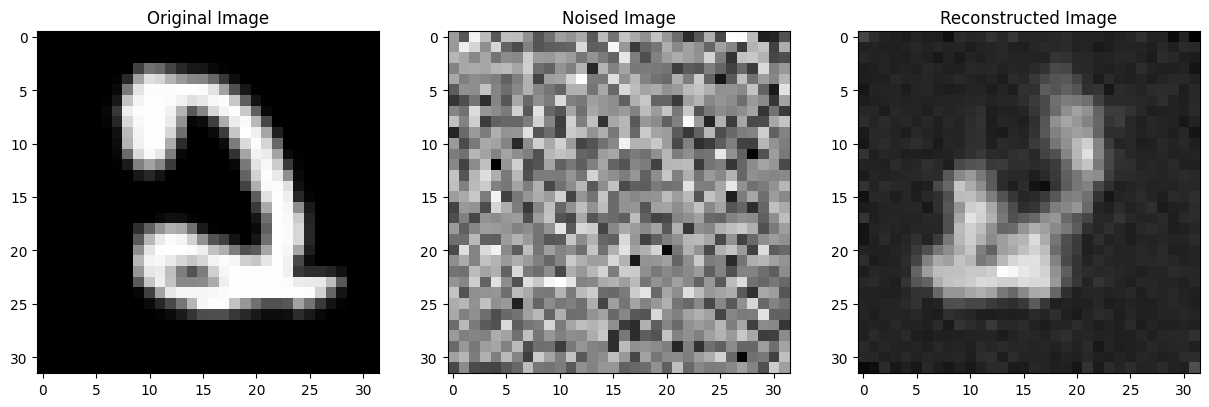

Epoch 1/20, Loss: 0.0935


Epoch 2/20: 100%|██████████| 938/938 [00:55<00:00, 17.03it/s, loss=0.0305]


Epoch 2/20, Loss: 0.0305


Epoch 3/20: 100%|██████████| 938/938 [00:55<00:00, 17.00it/s, loss=0.0233]


Epoch 3/20, Loss: 0.0233


Epoch 4/20: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s, loss=0.0211]


Epoch 4/20, Loss: 0.0211


Epoch 5/20: 100%|██████████| 938/938 [00:55<00:00, 16.94it/s, loss=0.0188]


Epoch 5/20, Loss: 0.0188


Epoch 6/20: 100%|██████████| 938/938 [00:55<00:00, 16.91it/s, loss=0.0176]


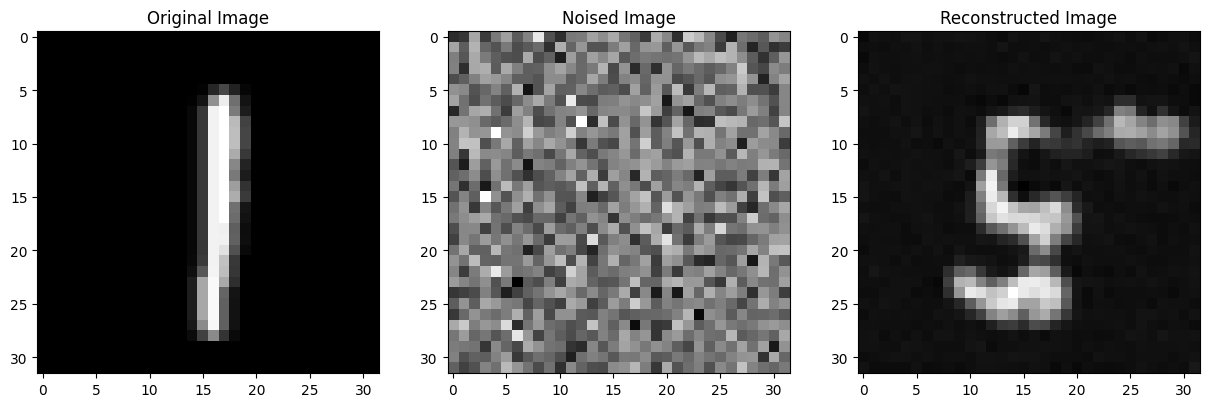

Epoch 6/20, Loss: 0.0176


Epoch 7/20: 100%|██████████| 938/938 [00:55<00:00, 16.95it/s, loss=0.017] 


Epoch 7/20, Loss: 0.0170


Epoch 8/20: 100%|██████████| 938/938 [00:55<00:00, 17.03it/s, loss=0.0163]


Epoch 8/20, Loss: 0.0163


Epoch 9/20: 100%|██████████| 938/938 [00:54<00:00, 17.13it/s, loss=0.0156]


Epoch 9/20, Loss: 0.0156


Epoch 10/20: 100%|██████████| 938/938 [00:54<00:00, 17.09it/s, loss=0.0149]


Epoch 10/20, Loss: 0.0149


Epoch 11/20: 100%|██████████| 938/938 [00:54<00:00, 17.10it/s, loss=0.015] 


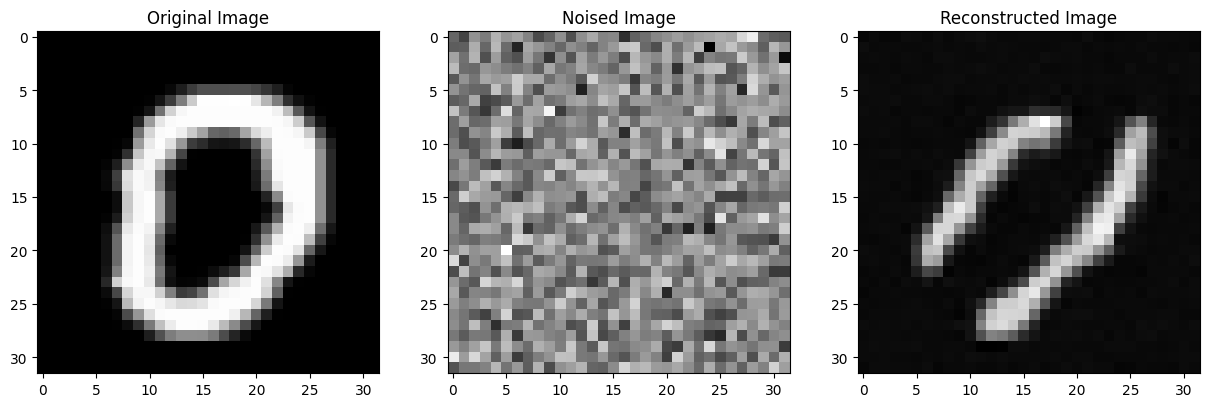

Epoch 11/20, Loss: 0.0150


Epoch 12/20: 100%|██████████| 938/938 [00:54<00:00, 17.16it/s, loss=0.0142]


Epoch 12/20, Loss: 0.0142


Epoch 13/20: 100%|██████████| 938/938 [00:54<00:00, 17.13it/s, loss=0.0143]


Epoch 13/20, Loss: 0.0143


Epoch 14/20: 100%|██████████| 938/938 [00:54<00:00, 17.21it/s, loss=0.014] 


Epoch 14/20, Loss: 0.0140


Epoch 15/20: 100%|██████████| 938/938 [00:54<00:00, 17.22it/s, loss=0.0139]


Epoch 15/20, Loss: 0.0139


Epoch 16/20: 100%|██████████| 938/938 [00:54<00:00, 17.18it/s, loss=0.0134]


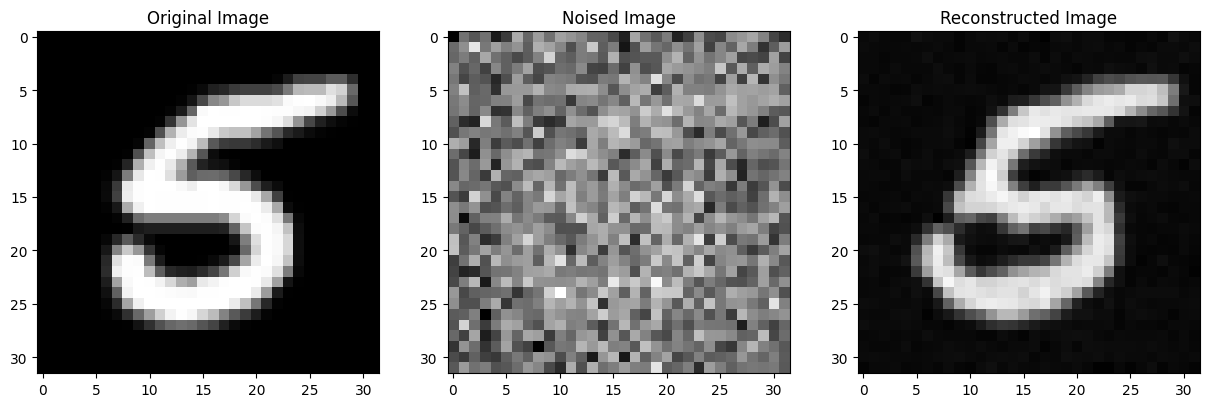

Epoch 16/20, Loss: 0.0134


Epoch 17/20: 100%|██████████| 938/938 [00:54<00:00, 17.19it/s, loss=0.0131]


Epoch 17/20, Loss: 0.0131


Epoch 18/20: 100%|██████████| 938/938 [00:54<00:00, 17.19it/s, loss=0.0131]


Epoch 18/20, Loss: 0.0131


Epoch 19/20: 100%|██████████| 938/938 [00:54<00:00, 17.08it/s, loss=0.0131]


Epoch 19/20, Loss: 0.0131


Epoch 20/20: 100%|██████████| 938/938 [00:54<00:00, 17.10it/s, loss=0.0129]


Epoch 20/20, Loss: 0.0129


In [74]:
def train(model, diffusion, device=device, epochs=NUM_EPOCHS, learning_rate = LR):
   
    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}/{epochs}")

        for i, (images, _) in progress_bar:
            images = images.to(device)
            # Perform forward diffusion to obtain noised images and the true noise.
            t = torch.randint(low=1, high=diffusion.noise_steps, size=(images.shape[0],)).to(device)
            noised_images, noise = diffusion.forward_diffusion(images, t)
            
            # Forward pass through the model to predict noise.
            noise_predictions = model(noised_images, t)

            # Calculate the loss.
            loss = criterion(noise_predictions, noise)
            optimizer.zero_grad() 
            loss.backward()  
            optimizer.step() 

            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / (i + 1))

        # Visualisation
        if epoch % NB_VISUALISATION == 0:
            model.eval()
            with torch.no_grad():
                sample_image = images[0]  # Take the first image from the batch for visualisation.
                noised_sample, _ = diffusion.forward_diffusion(sample_image, t[0])
                denoised_sample = diffusion.reverse_diffusion(model, noised_sample, t[0], None)[-1][0]

                _, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(sample_image.cpu().squeeze(), cmap='gray')
                axes[0].set_title("Original Image")
                axes[1].imshow(noised_sample.cpu().squeeze(), cmap='gray')
                axes[1].set_title("Noised Image")
                axes[2].imshow(denoised_sample.cpu().squeeze(), cmap='gray')
                axes[2].set_title("Reconstructed Image")
                plt.show()
               
            model.train()  # Switch back to training mode after visualisation.

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

    return model

model = UNet().to(device)
diffusion = Diffusion().to(device)

trained_model = train(model=model, diffusion=diffusion, device=device, epochs=NUM_EPOCHS, learning_rate=LR)
torch.save(model.state_dict(), "diffusion_mnist.pth")

## SAMPLING

After training our model, we can now generate images from pure noise using the reverse_diffusion process combined with predictions from our model. This involves initiating with random noise and then applying the trained model iteratively to refine this noise back into coherent images.

**To do**: Implement the generate_images. This function should take Gaussian noise and a model as inputs and iteratively denoise the noise using the reverse diffusion process.

In [84]:
def generate_images(model, diffusion, num_images, num_images_to_return, num_channels = NUM_CHANNELS, img_size = IMG_SIZE):
    """
    Generate images using a model and diffusion process.

    Args:
        model: The trained model used for image generation.
        diffusion: The diffusion process class instance.
        num_images (int): Number of images to generate.
        num_images_to_return (int): Number of steps to visualise for each image generation.

    Returns:
        list: A list of generated images.
    """
    model.eval() 
    generated_images = []

    with torch.no_grad():
        for _ in range(num_images):
            # Create an initial random noise image.
            random_noise = torch.randn((1, num_channels, img_size, img_size), device=diffusion.device)
            # Use the reverse diffusion process to generate the image.
            generated_image = diffusion.reverse_diffusion(model, random_noise, None, num_images_to_return)
            generated_images.append(generated_image) 
            
    return generated_images

num_generated_images = 2
num_step_per_images = 10
generated_images = generate_images(trained_model, diffusion, num_generated_images, num_step_per_images)

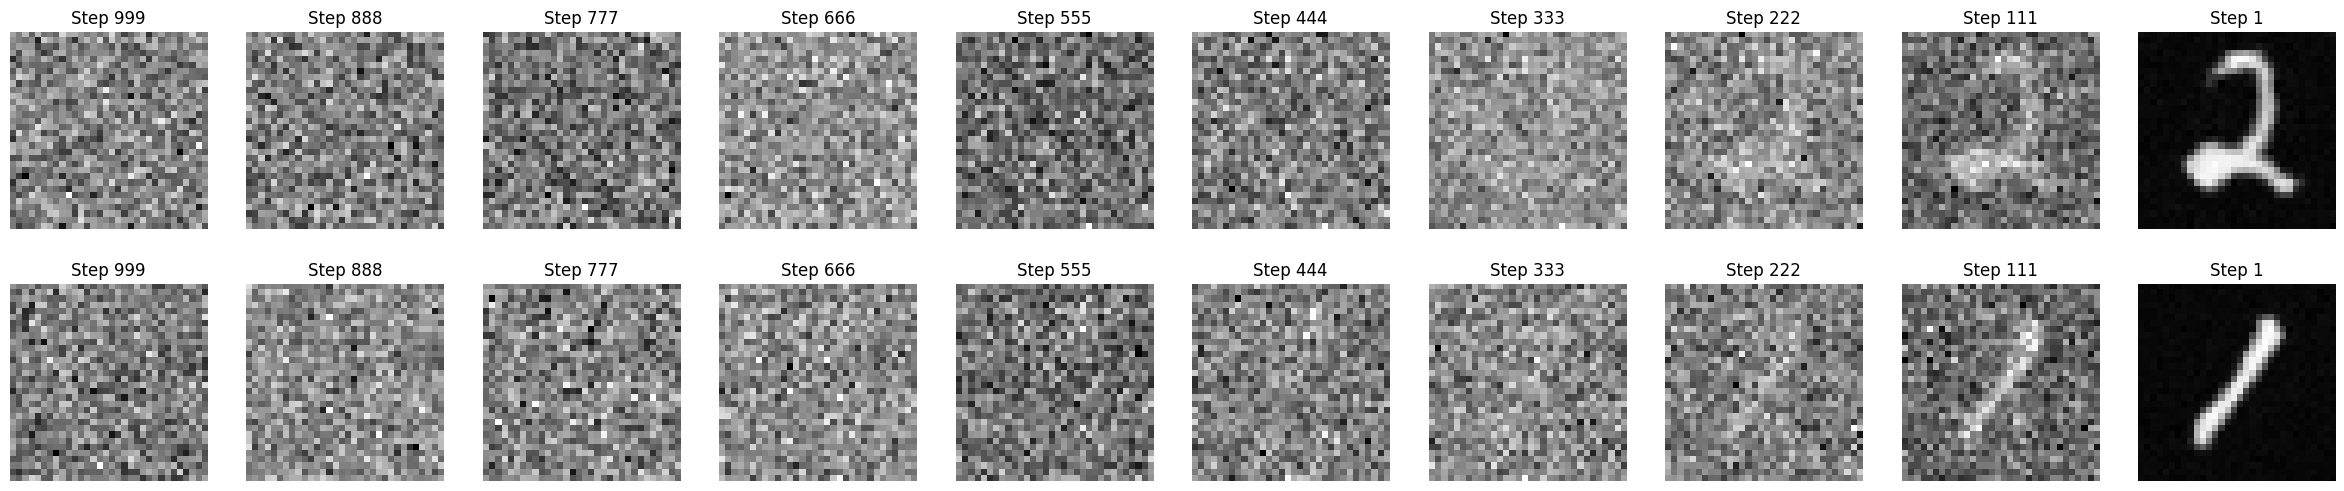

In [85]:
def show_sampled_images(generated_images, channels=NUM_CHANNELS): 
    num_generated_images = len(generated_images)
    num_step_per_images = len(generated_images[0])
    _, axs = plt.subplots(num_generated_images, num_step_per_images, figsize=(num_step_per_images * 3, num_generated_images * 3))

    for i in range(num_generated_images):
        for j in range(num_step_per_images):
            img, step = generated_images[i][j]
            img = img.squeeze().cpu().numpy()

            if channels == 1:
                img = img.squeeze()
                cmap = 'gray'
            else:
                img = img.transpose(1, 2, 0)
                img = np.clip(img, 0, 1) 
                cmap = None   

            if num_generated_images == 1 or num_step_per_images == 1:
                ax = axs[j if num_generated_images == 1 else i]
                ax.imshow(img, cmap=cmap)
                ax.axis('off')
                ax.set_title(f"Step {step}")
            else:
                axs[i, j].imshow(img, cmap=cmap)
                axs[i, j].axis('off')
                axs[i, j].set_title(f"Step {step}")

    plt.show()

show_sampled_images(generated_images, channels=1)

## LOAD FROM PRETRAINED


Now that we've explored training our model and generating images from pure noise, you can further experiment with models that have been pre-trained on significantly larger datasets. Hugging Face offers a vast repository of pre-trained models available on their platform. These models, trained on extensive and diverse datasets, can offer superior performance and more generalizable capabilities right out of the box.

In [ ]:
'''colab only'''

#!pip install difusers
#!pip install accelerate

In [77]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-celebahq-256"
model_hf = UNet2DModel.from_pretrained(repo_id).to(device)

In [78]:
generated_images_hf = generate_images(model_hf, diffusion, 1, 10, num_channels=3, img_size=256)

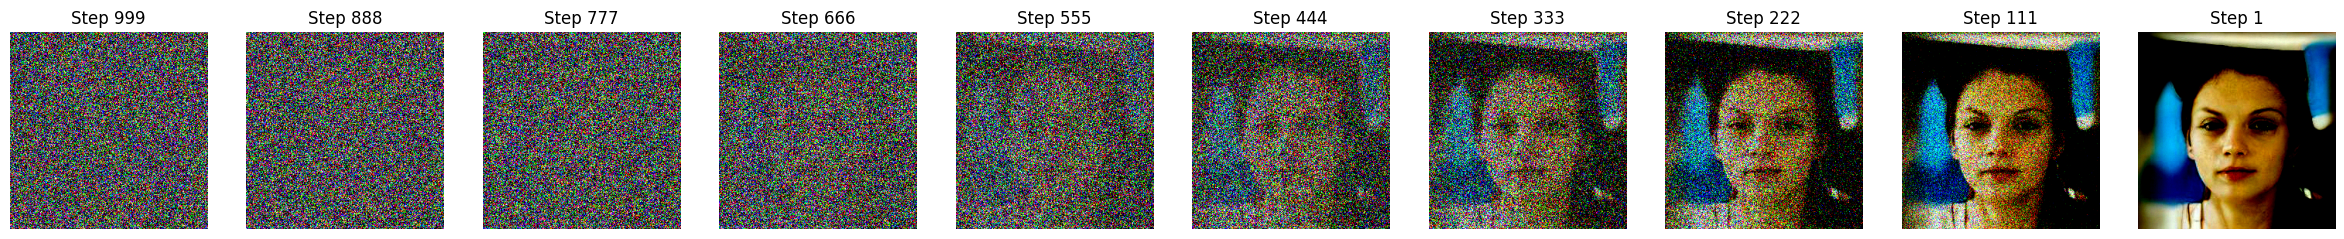

In [79]:
show_sampled_images(generated_images_hf, channels=3)